In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV


In [2]:
#Load the data we exported in the previous step
df = pd.read_csv('Combined_FIFA_FPL_Data.csv', low_memory=False)

In [3]:
#Check the length of the dataframe
print("\nLength of Frame:", len(df))

#Let us check for missing values in each of the columns
missing_values = df.isnull().sum().sort_values(ascending=False)
print("\nMissing Values: ")
for index, value in missing_values.items():
    print(f"{index}: {value}")


Length of Frame: 76317

Missing Values: 
team_y: 76317
team_x: 76317
Marking: 76317
Loaned From: 74783
Kit Number: 57254
starts: 49812
expected_assists: 49812
expected_goals: 49812
expected_goals_conceded: 49812
expected_goal_involvements: 49812
ShortPassing: 35742
HeadingAccuracy: 35742
Finishing: 35742
ShotPower: 35742
Crossing: 35742
Jersey Number: 35742
Volleys: 35742
Dribbling: 35742
Curve: 35742
FKAccuracy: 35742
LongPassing: 35742
BallControl: 35742
Acceleration: 35742
SprintSpeed: 35742
Reactions: 35742
Balance: 35742
Agility: 35742
Jumping: 35742
StandingTackle: 35742
DefensiveAwareness: 35742
Best Overall Rating: 35742
Best Position: 35742
GKReflexes: 35742
GKPositioning: 35742
Stamina: 35742
GKHandling: 35742
GKDiving: 35742
SlidingTackle: 35742
GKKicking: 35742
Composure: 35742
Vision: 35742
Positioning: 35742
Interceptions: 35742
Aggression: 35742
LongShots: 35742
Strength: 35742
Penalties: 35742
Joined: 18573
Release Clause: 18213
Contract Valid Until: 17039
Real Face: 1

In [4]:
#Following the joins, we can drop processed_name from the data
#We can also drop team_y, team_x and Marking - since these are always NULL
#name_y also should be dropped, as this is created as part of the joining process
df.drop(columns=['processed_name',
                 'team_y',
                 'team_x',
                 'Marking',
                 'name_y'], inplace=True)
'''
We can also see from the above that expected values and starts have not been collected for many seasons.
As such, it may be worth us trying two approaches, the first, using all historical data we have and 
the second using only the seasons where expected values are available. Perhaps we will see some 
significant difference.
'''
#For now, we shall drop those columns also
df.drop(columns=['starts',
                 'expected_assists',
                 'expected_goals',
                 'expected_goals_conceded',
                 'expected_goal_involvements',
                 'xP'], inplace=True)

#There are clearly several extra columns we can remove, namely: Loaned From, Kit Number, Unnamed: 0, 
# ID, Joined, Club Logo, Flag, Photo, Release Clause, Contract Valid Until
#These all should have no value in future points prediction
df.drop(columns=['Loaned From',
                 'Kit Number',
                 'Unnamed: 0',
                 'ID',
                 'Joined',
                 'Club Logo',
                 'Flag',
                 'Photo',
                 'Release Clause',
                 'Contract Valid Until'], inplace=True)

In [5]:
#Select the categorical columns for inspection
df_categorical = df.select_dtypes(include=[object])
df_categorical

,name_x,position,team,kickoff_time,Nationality,Value,Wage,Preferred Foot,Work Rate,Body Type,Real Face,Position,Height,Weight,Best Position
0,Aaron Connolly,FWD,Brighton,2020-09-14T19:15:00Z,Republic of Ireland,€2.6M,€23K,Right,Medium/ Low,Stocky (170-185),Yes,"<span class=""pos pos28"">SUB",5'8,170lbs,ST
1,Aaron Cresswell,DEF,West Ham,2020-09-12T19:00:00Z,England,€7M,€37K,Left,High/ Medium,Normal (170-185),Yes,"<span class=""pos pos7"">LB",5'9,146lbs,LB
2,Aaron Mooy,MID,Brighton,2020-09-14T19:15:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aaron Ramsdale,GK,Sheffield Utd,2020-09-14T17:00:00Z,England,€7.5M,€20K,Right,Medium/ Medium,Normal (185+),Yes,"<span class=""pos pos0"">GK",6'2,170lbs,GK
4,Abdoulaye Doucouré,MID,Everton,2020-09-13T15:30:00Z,France,€11M,€69K,Right,High/ Medium,PLAYER_BODY_TYPE_369,Yes,"<span class=""pos pos13"">RCM",6'0,168lbs,CDM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76312,Oliver Skipp,MID,Spurs,2023-05-28T15:30:00Z,England,€20M,€49K,Right,Medium/ High,Normal (170-185),Yes,"<span class=""pos pos28"">SUB",175cm,70kg,NaN
76313,Ryan Sessegnon,DEF,Spurs,2023-05-28T15:30:00Z,England,€12M,€53K,Left,High/ Medium,Lean (170-185),Yes,"<span class=""pos pos8"">LWB",178cm,70kg,NaN
76314,Ashley Young,DEF,Aston Villa,2023-05-28T15:30:00Z,England,€1.4M,€43K,Right,High/ Medium,Lean (170-185),Yes,"<span class=""pos pos29"">RES",175cm,65kg,NaN
76315,Jeremy Sarmiento Morante,MID,Brighton,2023-05-28T15:30:00Z,Ecuador,€2.1M,€12K,Right,Medium/ Medium,Lean (170-185),Yes,"<span class=""pos pos29"">RES",183cm,73kg,NaN


In [6]:
#From inspection we can see several columns that can be remove, Nationality should have little or no impact
# or at the very least will be explained by other variables. Body Type, Real Face, Position,
# and Best Position can also all be removed
df.drop(columns=['Nationality',
                 'Body Type',
                 'Real Face',
                 'Position',
                 'Best Position'], inplace=True)

#Additionally kickoff_time should be a datetime element, however, we can also exclude this from our work 
# for simplicity
df.drop(columns=['kickoff_time'], inplace=True)

In [7]:
#We also notice that Value, Wage, Height and Weight need some conversion to accurately represent the 
# numerical variables that they are.

#Let's start with Height
#Function to convert height in feet and inches to centimeters
def convert_to_cm(height):
    if pd.notna(height) and "'" in height:  # If height is not NULL and in feet and inches format
        feet, inches = map(int, height.split("'"))
        total_inches = (feet * 12) + inches
        return total_inches * 2.54
    elif pd.notna(height) and "cm" in height:  # If height is not NULL and in centimeters format
        return int(height.replace("cm", ""))
    else:
        return None 

#Apply the function to the 'height' column
df['Height'] = df['Height'].apply(convert_to_cm)

#Weight
#Function to convert weight in pounds to kilograms
def convert_to_kg(weight):
    if pd.notna(weight) and "lbs" in weight:  # If weight is not NULL and in pounds format
        pounds = int(weight.replace("lbs", ""))
        return pounds * 0.453592
    elif pd.notna(weight) and "kg" in weight:  # If weight is not NULL and in kilograms format
        return int(weight.replace("kg", ""))
    else:
        return None 

#Apply the function to the 'weight' column
df['Weight'] = df['Weight'].apply(convert_to_kg)

#Value and Wage
#Function to convert values to numeric
def convert_value_to_numeric(value):
    if pd.notna(value):
        value_lower = value.lower() # Remove case-sensitivity
        multiplier = 1
        if 'm' in value_lower: 
            multiplier = 1e6 # m denoting million
        elif 'k' in value_lower:
            multiplier = 1e3 # k denotion thousand

        #Extract numeric part from the value string
        numeric_value = ''.join(filter(str.isdigit, value))

        return float(numeric_value) * multiplier
    else:
        return None 

#Apply the function to the 'value' column
df['Value'] = df['Value'].apply(convert_value_to_numeric)

#Apply the same function to the 'wage' column
df['Wage'] = df['Wage'].apply(convert_value_to_numeric)


In [8]:
#Finally for these early stages, since our data is TimeSeries in nature, we should sort the data as such.
#We can do this by sorted on the GW (Game Week) and Year columns

# Sort the DataFrame on "Year" and "GW" columns in ascending order
df = df.sort_values(by=['Year', 'GW'], ascending=True)

In [9]:
#To handle missing values we need to split into numerical and categorical data
df_numeric = df.select_dtypes(include=[np.number])
df_categorical = df.select_dtypes(exclude=[np.number])

#As discussed in my Methodology there are several methods of handling missing values
#Method 1: Deletion - deleting rows with missing values
df_deletion = df.dropna()

#Method 2: Mean Imputation - replacing missing values with the mean of the column
df_mean_imputation = df_numeric.fillna(df_numeric.mean())

#Method 3: Multivariate Imputation - replacing missing values by 
# modeling each feature with missing values as a function of other features
imputer = IterativeImputer(max_iter=10, random_state=0)
df_imputed = df_numeric.copy()
df_imputed[df_numeric.columns] = imputer.fit_transform(df_numeric)

#Method 4: KNN Imputation - replacing missing values using the k-Nearest Neighbors approach
knn_imputer = KNNImputer(n_neighbors=5)  #Use 5 nearest neighbors
df_knn_imputed = df_numeric.copy()
df_knn_imputed[df_numeric.columns] = knn_imputer.fit_transform(df_numeric)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


I expect KNN to be a good fit for imputing missing values, largely because there is considerable spread across the data, such that just choosing the global mean may cause some problems. Unfortunately it isn't perfect as we have some strong correlalations between some variables, as shown below. Particularly in relation to the FIFA Data.

Correlation Matrix:


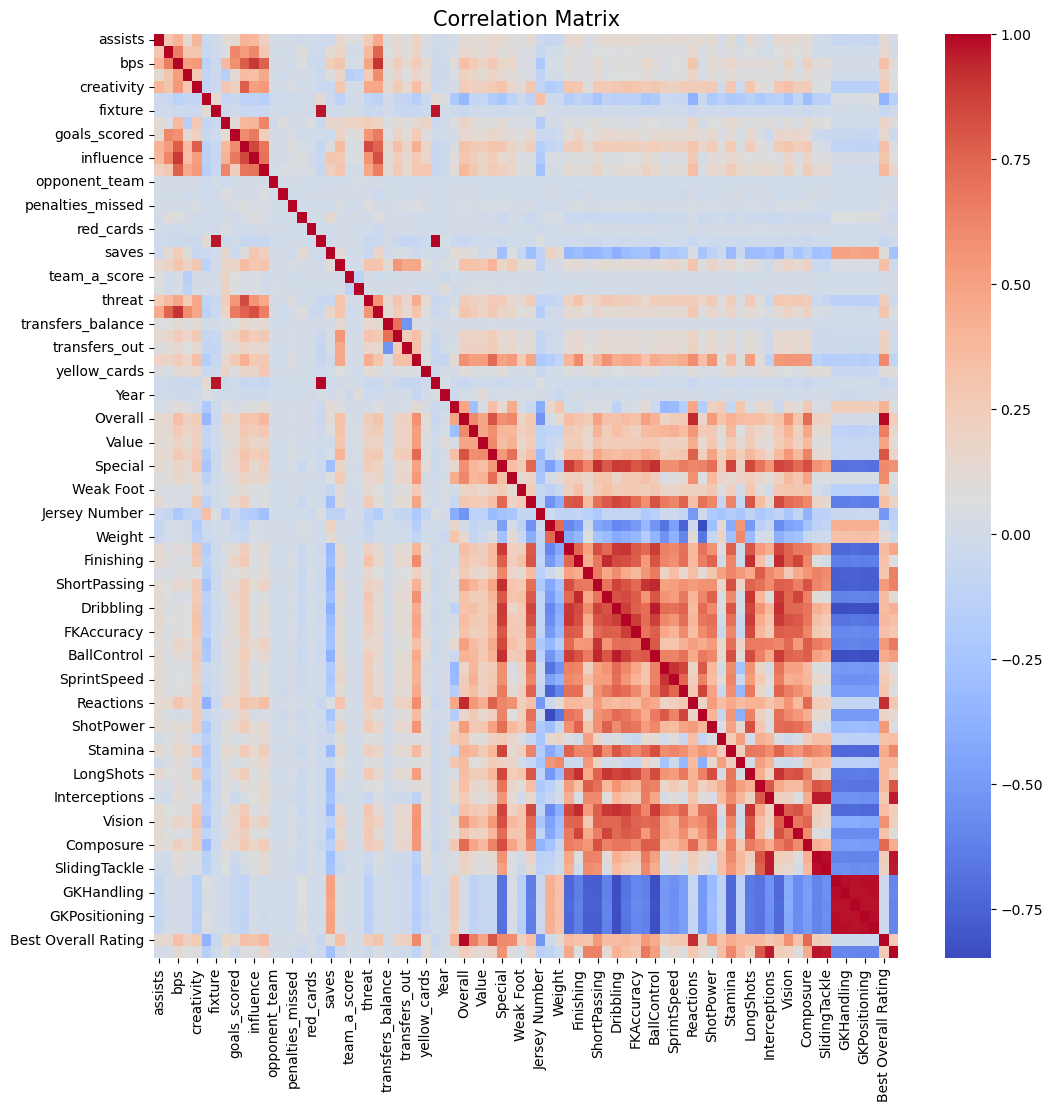

In [10]:
#Correlation matrix (for numerical columns)
print("Correlation Matrix:")
correlation_matrix = df_numeric.corr()

#Plot the heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix", fontsize=15)  # Adjust the title font size
plt.show()

In [11]:
#In the interest of being able to try each method as efficiently as possible
#we set below and can re-run our code as necessary:
# df_numeric = df_deletion
# df_numeric = df_mean_imputation
# df_numeric = df_imputed
df_numeric = df_knn_imputed

#Finally concatenate the numerical and categorical dataframes together again
df = pd.concat([df_numeric, df_categorical], axis=1)

In [12]:
#As discussed in my Methodology, there are 3 methods we will use to identify outliers
# these are detailed below

#Select only numeric columns for Outlier detection
numeric_cols = df.select_dtypes(include=[np.number])

#Identify outliers using box plots - 
# this proved too messy, we will recheck following dimensionality reduction
# for column in df.columns:
#     if df[column].dtype in ['int64', 'float64']:  #Numerical only
#         plt.figure(figsize=(12, 6))
#         df.boxplot([column])
#         plt.title(f'Boxplot of {column}')
#         plt.show()

#Identify outliers using z-score
z_scores = stats.zscore(df.select_dtypes(include=[np.number]))  # Apply z-score for numerical columns only
df_z_scores = pd.DataFrame(z_scores, columns=df.select_dtypes(include=[np.number]).columns)
outliers_z_scores = (df_z_scores > 3).sum().sort_values(ascending=False)  # Consider values with z-score > 3 as outliers

print("\nOutliers identified using Z-Scores: ")
print(outliers_z_scores)

#Identify outliers using IQR
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1
print("\nIQR Values: ")
print(IQR)

#Identify the outliers
outliers = ((numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR)))

#Print the outliers
print("\nRows containing at least one \'outlier\' in the DataFrame:")
print(len(outliers.loc[outliers.any(axis=1)]))




Outliers identified using Z-Scores: 
clean_sheets          7216
GKPositioning         4275
GKDiving              4136
GKHandling            4115
GKReflexes            4024
                      ... 
Dribbling                0
Curve                    0
FKAccuracy               0
LongPassing              0
DefensiveAwareness       0
Length: 78, dtype: int64

IQR Values: 
assists                 0.0
bonus                   0.0
bps                     9.0
clean_sheets            0.0
creativity              1.6
                       ... 
GKKicking               6.0
GKPositioning           5.8
GKReflexes              5.0
Best Overall Rating     7.8
DefensiveAwareness     32.0
Length: 78, dtype: float64

Rows containing at least one 'outlier' in the DataFrame:
61558


Clearly we can see considerable "outliers", but this is to be expected given the nature of the data. We will perform some standardisation and then revisit these outliers again later after we encode our categorical variables and perform dimensionality reduction.

In [13]:
#Normalise data using standard scaler
scaler = StandardScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df.select_dtypes(include=[np.number])), 
                             columns=df.select_dtypes(include=[np.number]).columns)


Now that we've completed our normalisation, let's look at our categorical variables, ideally we should use One-Hot encoding for those which are nominal and Label encoding for those which are ordinal.

In [14]:
#Select the categorical columns for inspection
df_categorical = df.select_dtypes(include=[object])
df_categorical

,name_x,position,team,Preferred Foot,Work Rate
0,Aaron Connolly,FWD,Brighton,Right,Medium/ Low
1,Aaron Cresswell,DEF,West Ham,Left,High/ Medium
2,Aaron Mooy,MID,Brighton,NaN,NaN
3,Aaron Ramsdale,GK,Sheffield Utd,Right,Medium/ Medium
4,Abdoulaye Doucouré,MID,Everton,Right,High/ Medium
...,...,...,...,...,...
76312,Oliver Skipp,MID,Spurs,Right,Medium/ High
76313,Ryan Sessegnon,DEF,Spurs,Left,High/ Medium
76314,Ashley Young,DEF,Aston Villa,Right,High/ Medium
76315,Jeremy Sarmiento Morante,MID,Brighton,Right,Medium/ Medium


In [15]:
#We can see from inspection that the categorical variables are all nominal (i.e. they have no order)
#As such, One-Hot encoding is appropriate for all our variables.

#Now is a good time to convert name_x into some ID (since it avoids our normalisation)
#We will do this using factorize()
df_categorical['ID'] = pd.factorize(df['name_x'])[0]

#In order to let us convert these back from our final models, we will create a dictionary also
id_name_dict = dict(zip(df_categorical['ID'], df_categorical['name_x']))
#We can now also drop the name_x column
df_categorical.drop(columns=['name_x'], inplace=True)

#Perform one-hot encoding on the categorical columns
one_hot_encoded = pd.get_dummies(df_categorical)

#Combine the one-hot encoded and normalised dataframes
df_processed = pd.concat([df_normalized, one_hot_encoded], axis=1)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### Random Forest Regressor (Feature Selection)

We are now ready to perform our dimensionality reduction. Random Forest Regressors can handle both numerical and categorical data as well as not requiring data to be scaled. They also provide a very easy to interpret measure of feature importance, as such, we'll use this first and re-visit if needed.

In [16]:
#Since we are looking to predict'total_points' let's split these into X and y
X = df_processed.drop('total_points', axis=1)
y = df_processed['total_points']

#Since BPS and Bonus are directly related to our output total_points, we shall remove them
# (they are essentially sub sets of this value) 
X.drop(columns=['bps',
                'bonus'], inplace=True)

#Splitting into training and test datasets (80-20 split seems standard from my literature review)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [17]:
#Select the RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

#Get feature importances
importances = model.feature_importances_
f_importances = pd.Series(importances, X.columns) # Feature importance alongside the Variable
f_importances.sort_values(ascending=False, inplace=True) # Sorting

#Print the importances for visual inspection
print(f_importances)

influence                0.491545
clean_sheets             0.230579
minutes                  0.078398
assists                  0.054242
goals_scored             0.042469
                           ...   
Work Rate_Low/ Low       0.000006
Work Rate_Low/ Medium    0.000004
team_Sheffield Utd       0.000003
team_Bournemouth         0.000002
position_GKP             0.000001
Length: 117, dtype: float64


In [18]:
#Select only the features with importance above a certain threshold
selected_features = f_importances[f_importances > 0.005].index

print(selected_features)

Index(['influence', 'clean_sheets', 'minutes', 'assists', 'goals_scored',
       'position_DEF', 'goals_conceded', 'yellow_cards', 'position_GK',
       'creativity'],
      dtype='object')


In [19]:
# Refit the model using only the selected features
model.fit(X_train[selected_features], y_train)

RandomForestRegressor(random_state=0)

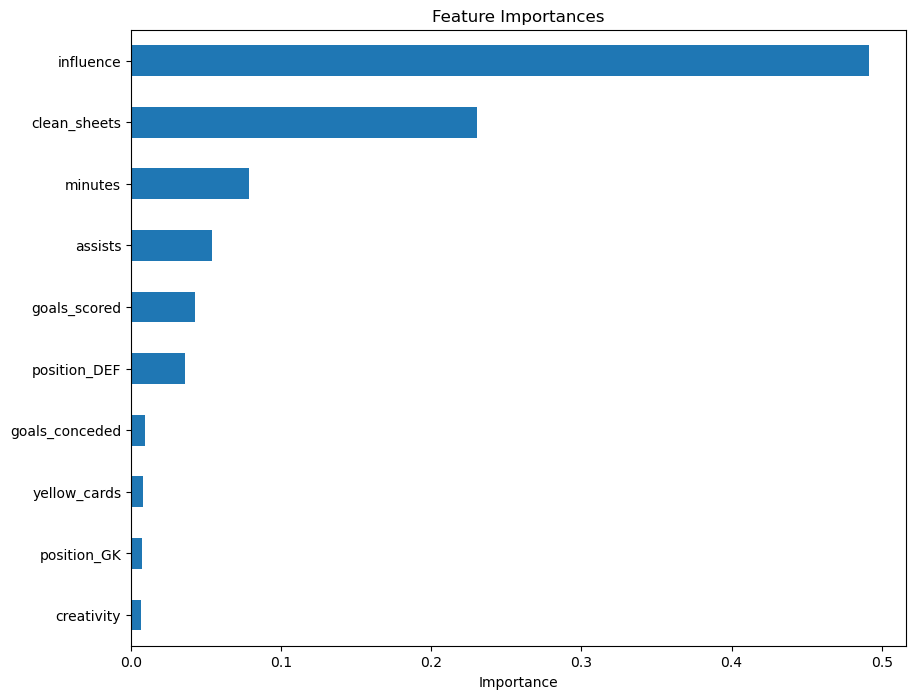

In [20]:
#Plotting feature importances
plt.figure(figsize=(10,8))
f_importances[selected_features].sort_values().plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.show()

#### Lasso regularization (Feature Selection)

Since all variables have been scaled and one-hot encoding has been used on categorical variables, we could consider using Lasso regularization for feature selection. Lasso (Least Absolute Shrinkage and Selection Operator) has the ability to shrink the coefficients of less important features to exactly 0, effectively performing feature selection.

In [21]:
#Define the model
lasso = LassoCV(cv=5)

#Fit the model
lasso.fit(X_train, y_train)

LassoCV(cv=5)

In [22]:
#Convert coefficients to a pandas series
lasso_coeffs = pd.Series(lasso.coef_, index = X_train.columns)

print(lasso_coeffs)

assists                     0.209155
clean_sheets                0.323045
creativity                  0.000000
element                    -0.000000
fixture                     0.000000
                              ...   
Work Rate_Low/ Low         -0.000000
Work Rate_Low/ Medium      -0.000000
Work Rate_Medium/ High     -0.000000
Work Rate_Medium/ Low       0.000000
Work Rate_Medium/ Medium    0.000000
Length: 117, dtype: float64


In [23]:
#Select features which coefficients are not 0
selected_features = lasso_coeffs[lasso_coeffs!=0].index

print(selected_features)

Index(['assists', 'clean_sheets', 'goals_scored', 'influence', 'minutes',
       'own_goals', 'penalties_saved', 'red_cards', 'saves', 'yellow_cards',
       'ID'],
      dtype='object')


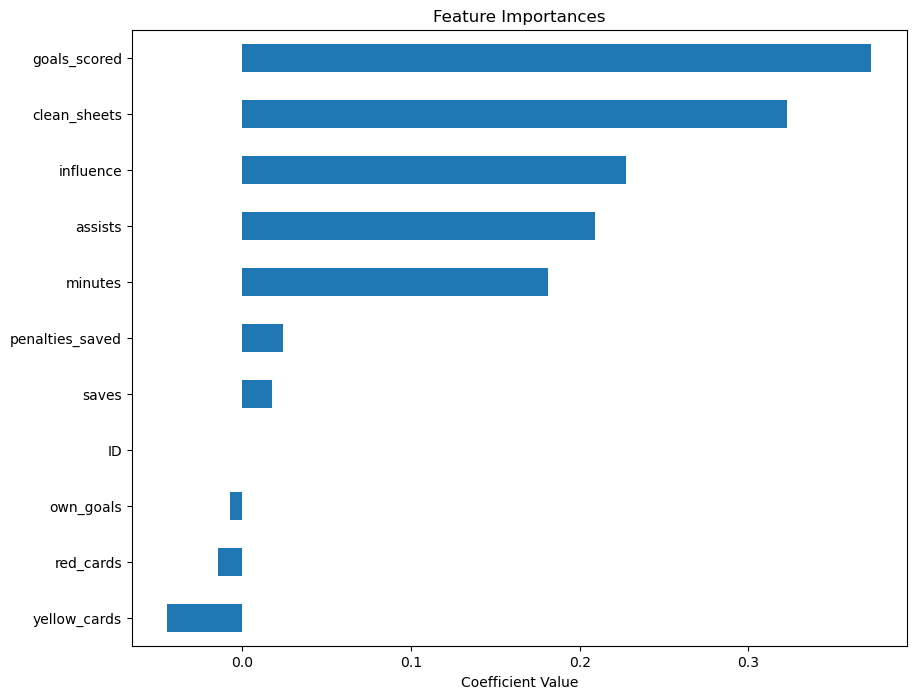

In [24]:
#Plotting feature importances
plt.figure(figsize=(10,8))
lasso_coeffs[selected_features].sort_values().plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Coefficient Value')
plt.show()

Lasso appears to provide us with the best selection of Features based, particularly when taking into consideration features that appeared relevant in other works explored during my Literature Review. As such, we will use this selection of Features for our final models.

In [39]:
df_processed

,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,...,Preferred Foot_Right,Work Rate_High/ High,Work Rate_High/ Low,Work Rate_High/ Medium,Work Rate_Low/ High,Work Rate_Low/ Low,Work Rate_Low/ Medium,Work Rate_Medium/ High,Work Rate_Medium/ Low,Work Rate_Medium/ Medium
0,-0.17861,-0.206931,-0.900219,-0.323151,-0.387103,-1.313746,-1.766189,1.624735,-0.183397,0.661292,...,1,0,0,0,0,0,0,0,1,0
1,-0.17861,-0.206931,0.602330,-0.323151,0.699708,0.490519,-1.775383,1.624735,-0.183397,0.240951,...,0,0,0,1,0,0,0,0,0,0
2,-0.17861,-0.206931,-0.578244,-0.323151,-0.417015,-1.404718,-1.766189,-0.482857,-0.183397,-0.529675,...,0,0,0,0,0,0,0,0,0,0
3,-0.17861,-0.206931,0.709655,-0.323151,-0.417015,0.733109,-1.756995,1.624735,-0.183397,0.100837,...,1,0,0,0,0,0,0,0,0,1
4,-0.17861,-0.206931,1.568254,3.094524,4.029937,0.879674,-1.793770,-0.482857,-0.183397,1.887287,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76312,-0.17861,-0.206931,1.138954,-0.323151,-0.417015,0.520842,1.635502,0.570939,-0.183397,-0.529675,...,1,0,0,0,0,0,0,1,0,0
76313,-0.17861,-0.206931,-0.578244,-0.323151,-0.417015,0.495572,1.635502,-0.482857,-0.183397,-0.529675,...,0,0,0,1,0,0,0,0,0,0
76314,-0.17861,-0.206931,-0.578244,-0.323151,-0.417015,1.011077,1.589533,-0.482857,-0.183397,-0.529675,...,1,0,0,1,0,0,0,0,0,0
76315,-0.17861,-0.206931,-0.578244,-0.323151,-0.417015,-1.106534,1.589533,-0.482857,-0.183397,-0.529675,...,1,0,0,0,0,0,0,0,0,1


In [43]:
#Assign the final output to a new DataFrame
df_ML = df_processed[['total_points',
                      'assists', 
                      'clean_sheets', 
                      'goals_scored', 
                      'influence', 
                      'minutes',
                      'own_goals', 
                      'penalties_saved', 
                      'red_cards', 
                      'saves', 
                      'yellow_cards',
                      'ID']]

#Export the final DataFrame to a CSV file, we can then use this for our future stages
output_filename = 'Machine_Learning_Data.csv'
df_ML.to_csv(output_filename)


#Convert the Dictionary to a List and then to a DataFrame
items_list = list(id_name_dict.items())
id_name_df = pd.DataFrame(items_list)

#Export to CSV file
output_filename = 'id_name_list.csv'
id_name_df.to_csv(output_filename, index=False) 